In [3]:
# Core
import numpy as np
import pandas as pd

# Plots (matplotlib only)
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Utils
import joblib, json, os, warnings
warnings.filterwarnings("ignore")

# Paths
CSV_PATH = "../data/Mall_Customers.csv"  # upload this file in Colab
ART_DIR = "mall_segments_artifacts"
os.makedirs(ART_DIR, exist_ok=True)


Load and clean data
Why: Clean data gives stable groups.
Steps: rename columns, strip text, drop nulls, encode gender.

In [4]:
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("$","").lower()
              for c in df.columns]
df = df.rename(columns={"genre":"gender"})  # some files use "Genre"

# Standardize common variants
if "annual_income_k" not in df.columns:
    for c in df.columns:
        if "annual" in c and "income" in c:
            df = df.rename(columns={c:"annual_income_k"})
if "spending_score" not in df.columns:
    for c in df.columns:
        if "spending" in c and "score" in c:
            df = df.rename(columns={c:"spending_score"})
if "customerid" not in df.columns:
    for c in df.columns:
        if "customer" in c and "id" in c:
            df = df.rename(columns={c:"customerid"})

# Trim, drop dups/nulls
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()
df = df.drop_duplicates().dropna()

# Encode gender
le = LabelEncoder()
df["gender_enc"] = le.fit_transform(df["gender"])

# Feature set
features = ["gender_enc", "age", "annual_income_k", "spending_score"]
X = df[features].copy()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(df.head(3))


   customerid  gender  age  annual_income_k  spending_score  gender_enc
0           1    Male   19               15              39           1
1           2    Male   21               15              81           1
2           3  Female   20               16               6           0


EDA quick views
Why: See shape and spread.
Plots: histograms and a scatter.

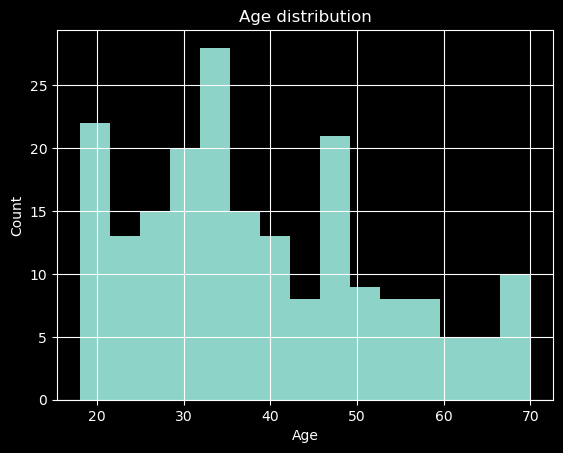

In [5]:
# Age
plt.figure()
df["age"].hist(bins=15)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


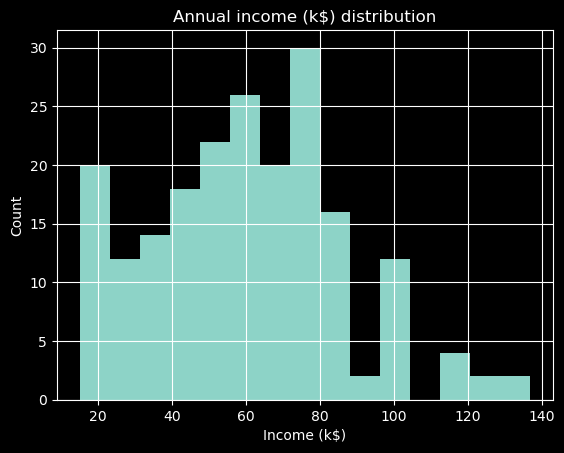

In [6]:
# Income
plt.figure()
df["annual_income_k"].hist(bins=15)
plt.title("Annual income (k$) distribution")
plt.xlabel("Income (k$)")
plt.ylabel("Count")
plt.show()


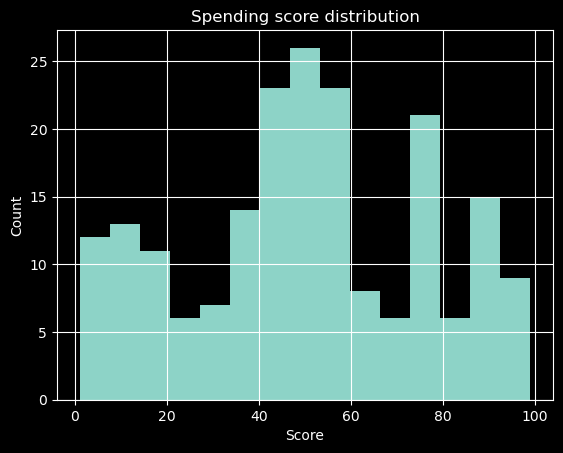

In [7]:
# Spending
plt.figure()
df["spending_score"].hist(bins=15)
plt.title("Spending score distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()


Model selection
Goal: Pick k for K-Means.
How: Try k=2 to 8. Pick best silhouette.
Also: Compare one Agglomerative run.

In [8]:
k_rows, km_models = [], {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)
    ch  = calinski_harabasz_score(X_scaled, labels)
    k_rows.append({"k":k, "silhouette":sil, "davies_bouldin":db, "calinski_harabasz":ch})
    km_models[k] = km

comp = pd.DataFrame(k_rows).sort_values("silhouette", ascending=False)
best_k = int(comp.iloc[0]["k"])
best_km = km_models[best_k]

print("Best k by silhouette:", best_k)
comp


Best k by silhouette: 8


,k,silhouette,davies_bouldin,calinski_harabasz
6,8,0.387993,0.944530,82.422775
5,7,0.357377,0.980158,76.778271
4,6,0.334738,1.018157,74.052211
3,5,0.314376,1.136414,70.387991
2,4,0.301232,1.291819,69.782556
1,3,0.259513,1.357408,66.772770
0,2,0.251815,1.613751,71.020516


In [9]:

from sklearn.cluster import KMeans

best_k = 8
best_km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(X_scaled)
df["segment"] = best_km.labels_
print("k fixed to:", best_k)


k fixed to: 8


In [10]:
# Counts
counts = df["segment"].value_counts().sort_index()
print("Counts per segment:\n", counts)

# Centers back to original scale
centers = pd.DataFrame(
    scaler.inverse_transform(best_km.cluster_centers_),
    columns=features
).round(1)
centers.insert(0, "segment", range(best_k))
centers["count"] = counts.values
centers


Counts per segment:
 segment
0    18
1    37
2    19
3    24
4    34
5    22
6    27
7    19
Name: count, dtype: int64


,segment,gender_enc,age,annual_income_k,spending_score,count
0,0,1.0,33.3,87.1,82.7,18
1,1,0.0,50.9,47.2,40.8,37
2,2,1.0,38.5,85.9,14.2,19
3,3,1.0,25.2,41.2,60.9,24
4,4,0.0,26.0,39.5,59.5,34
5,5,-0.0,32.5,85.3,80.6,22
6,6,1.0,58.0,47.6,38.9,27
7,7,-0.0,41.2,87.9,24.6,19


Quality checks (silhouette + PCA)
Why: Confirm cluster quality and show a 2D view.

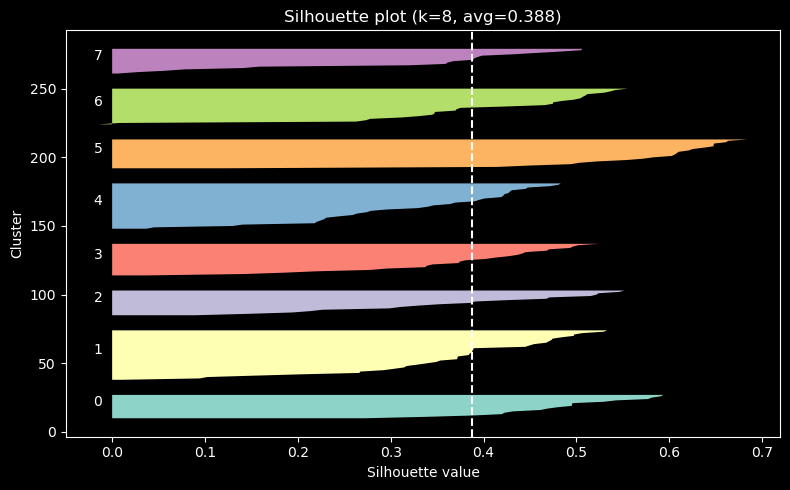

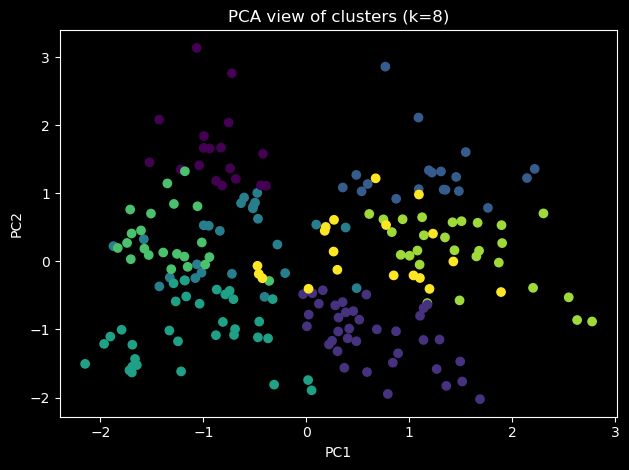

In [11]:
# Quality checks (silhouette + PCA)

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


labels = df["segment"].values

# Silhouette plot
s_vals = silhouette_samples(X_scaled, labels)
s_avg = silhouette_score(X_scaled, labels)

y_lower = 10
plt.figure(figsize=(8,5))
for i in range(best_k):
    sv = np.sort(s_vals[labels==i])
    size = sv.shape[0]
    y_upper = y_lower + size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, sv)
    plt.text(-0.02, y_lower + 0.5*size, str(i))
    y_lower = y_upper + 10

plt.axvline(x=s_avg, linestyle="--")
plt.xlabel("Silhouette value")
plt.ylabel("Cluster")
plt.title(f"Silhouette plot (k={best_k}, avg={s_avg:.3f})")
plt.tight_layout()
plt.savefig("silhouette_k8.png", dpi=150)
plt.show()

# PCA 2D view
pca = PCA(n_components=2, random_state=42)
pts2 = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(pts2[:,0], pts2[:,1], c=labels)
plt.title("PCA view of clusters (k=8)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("pca_clusters_k8.png", dpi=150)
plt.show()


Classifier to predict segments

In [12]:
# Classifier to predict segments

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["segment"], test_size=0.2, random_state=42, stratify=df["segment"]
)

rf = RandomForestClassifier(random_state=42)
grid = {"n_estimators":[150, 250], "max_depth":[None, 10]}
gs = GridSearchCV(rf, grid, cv=3, scoring="f1_macro", n_jobs=-1)
gs.fit(X_train, y_train)

best_rf = gs.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best RF params:", gs.best_params_)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Best RF params: {'max_depth': None, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4

    accuracy                           0.97        40
   macro avg       0.98      0.98      0.98        40
weighted avg       0.98      0.97      0.97        40

Confusion matrix:
 [[4 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 5 0 0 0 0]
 [0 1 0 0 6 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 4]]


In [13]:
# Export Models in pkl format

import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Export the trained classifier
classifier_path = os.path.join(models_dir, "customer_segmentation_model.pkl")
joblib.dump(best_rf, classifier_path)
print(f"Classifier saved to: {classifier_path}")

# Export the scaler
scaler_path = os.path.join(models_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Export the label encoder for gender (optional, for reference)
encoder_path = os.path.join(models_dir, "label_encoder.pkl")
joblib.dump(le, encoder_path)
print(f"Label encoder saved to: {encoder_path}")

Classifier saved to: ../models/customer_segmentation_model.pkl
Scaler saved to: ../models/scaler.pkl
Label encoder saved to: ../models/label_encoder.pkl
